<a href="https://colab.research.google.com/github/Vishwas2629/Dissertation/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
movie_reviews = pd.read_csv('IMDB_Dataset.csv', encoding='utf-8')
movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

In [ ]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
movie_reviews['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

<AxesSubplot:xlabel='sentiment', ylabel='count'>

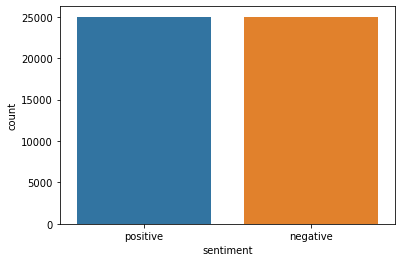

In [ ]:
import seaborn as sns
sns.countplot(x = 'sentiment', data = movie_reviews)

## Data Preprocessing


In [ ]:
def preprocess_text(sen):
  sentence = remove_tags(sen) #remove html tags
  sentence = re.sub('[^a-zA-Z]', ' ', sentence) #keeping only letters
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) #removing single character
  sentence = re.sub(r'\s+', ' ', sentence)#removing multiple spaces
  sentence = sentence.lower()


  return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
  return TAG_RE.sub('', text)

In [ ]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
  X.append(preprocess_text(sen))


In [ ]:
X[3]
#basic famili littl boy jake think zombi closet parent fight time movi slower soap opera suddenli jake decid becom rambo kill zombi ok first go make film must decid thriller drama drama movi watchabl parent divorc argu like real life jake closet total ruin film expect see boogeyman similar movi instead watch drama meaningless thriller spot well play parent descent dialog shot jake ignor

'basically there a family where little boy jake thinks there a zombie in his closet his parents are fighting all the time this movie is slower than soap opera and suddenly jake decides to become rambo and kill the zombie ok first of all when you re going to make film you must decide if its thriller or drama as drama the movie is watchable parents are divorcing arguing like in real life and then we have jake with his closet which totally ruins all the film expected to see boogeyman similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs as for the shots with jake just ignore them '

In [ ]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x == "positive" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Embedding Layer

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
len(X_train[5])

109

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
len(X_train[5])

100

In [ ]:
print(vocab_size)

92547


In [ ]:
#GloVe Embeddings
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size,100))
for word, index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [ ]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 [-0.071953    0.23127     0.023731   ... -0.71894997  0.86894
   0.19539   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.37771001  0.22946    -0.30311    ... -0.33610001  0.02637
  -0.72302002]
 [ 0.99882001  0.044       0.58508003 ... -0.54869002  0.15141
   1.36880004]]


## Simple Neural Network

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9254700   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, epochs = 6, validation_split= 0.2, batch_size= 128, verbose= 1)

Epoch 1/6
250/250 [==============================] - 2s 5ms/step - loss: 0.6085 - acc: 0.6662 - val_loss: 0.5339 - val_acc: 0.7295
Epoch 2/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4992 - acc: 0.7592 - val_loss: 0.5189 - val_acc: 0.7414
Epoch 3/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4659 - acc: 0.7807 - val_loss: 0.5267 - val_acc: 0.7401
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4384 - acc: 0.7978 - val_loss: 0.5207 - val_acc: 0.7465
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4198 - acc: 0.8083 - val_loss: 0.5629 - val_acc: 0.7259
Epoch 6/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4115 - acc: 0.8138 - val_loss: 0.5336 - val_acc: 0.7416


In [ ]:
score = model.evaluate(X_test,y_test, verbose=1)

313/313 [==============================] - 0s 1ms/step - loss: 0.5373 - acc: 0.7392


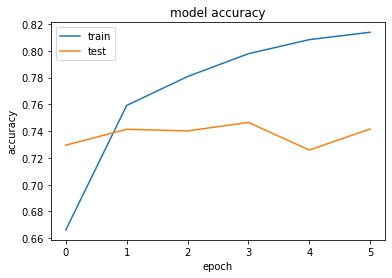

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


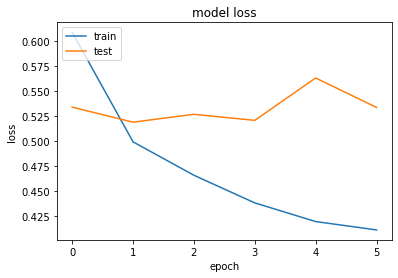

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# CNN

In [ ]:
from keras.layers.convolutional import Conv1D 
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9254700   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 10s 40ms/step - loss: 0.4959 - acc: 0.7569 - val_loss: 0.4093 - val_acc: 0.8126
Epoch 2/6
250/250 [==============================] - 12s 46ms/step - loss: 0.3665 - acc: 0.8387 - val_loss: 0.3818 - val_acc: 0.8234
Epoch 3/6
250/250 [==============================] - 10s 38ms/step - loss: 0.3189 - acc: 0.8648 - val_loss: 0.3503 - val_acc: 0.8430
Epoch 4/6
250/250 [==============================] - 9s 37ms/step - loss: 0.2782 - acc: 0.8883 - val_loss: 0.3564 - val_acc: 0.8382
Epoch 5/6
250/250 [==============================] - 9s 36ms/step - loss: 0.2421 - acc: 0.9068 - val_loss: 0.3541 - val_acc: 0.8379
Epoch 6/6
313/313 [==============================] - 1s 3ms/step - loss: 0.3349 - acc: 0.8533


In [ ]:
score = model.evaluate(X_test,y_test, verbose=1)

313/313 [==============================] - ETA: 0s - loss: 0.3340 - acc: 0.854 - 1s 3ms/step - loss: 0.3349 - acc: 0.8533


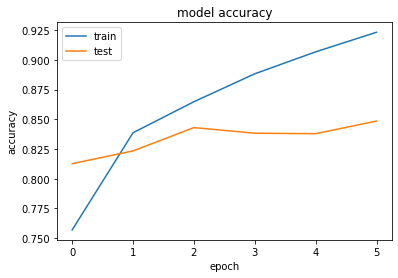

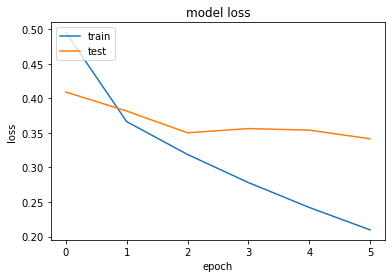

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# LSTM

In [ ]:
from keras.layers.recurrent import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9254700   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 64s 252ms/step - loss: 0.5460 - acc: 0.7192 - val_loss: 0.4491 - val_acc: 0.7886
Epoch 2/6
250/250 [==============================] - 68s 272ms/step - loss: 0.4424 - acc: 0.7939 - val_loss: 0.4181 - val_acc: 0.8155
Epoch 3/6
250/250 [==============================] - 70s 282ms/step - loss: 0.3958 - acc: 0.8207 - val_loss: 0.3733 - val_acc: 0.8321
Epoch 4/6
250/250 [==============================] - 65s 261ms/step - loss: 0.3694 - acc: 0.8347 - val_loss: 0.3572 - val_acc: 0.8407
Epoch 5/6
250/250 [==============================] - 68s 271ms/step - loss: 0.3509 - acc: 0.8436 - val_loss: 0.3506 - val_acc: 0.8436
Epoch 6/6
313/313 [==============================] - 6s 20ms/step - loss: 0.3434 - acc: 0.8495


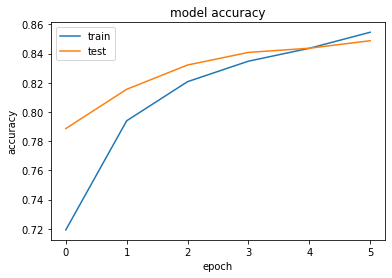

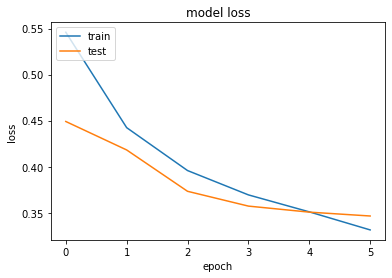

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# GRU

In [ ]:
from keras.layers import GRU
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(GRU(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          9254700   
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 9,315,401
Trainable params: 60,701
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 31s 117ms/step - loss: 0.5247 - acc: 0.7287 - val_loss: 0.4192 - val_acc: 0.8099
Epoch 2/6
250/250 [==============================] - 29s 117ms/step - loss: 0.3970 - acc: 0.8190 - val_loss: 0.3766 - val_acc: 0.8284
Epoch 3/6
250/250 [==============================] - 30s 122ms/step - loss: 0.3636 - acc: 0.8383 - val_loss: 0.3656 - val_acc: 0.8401
Epoch 4/6
250/250 [==============================] - 31s 123ms/step - loss: 0.3406 - acc: 0.8510 - val_loss: 0.3548 - val_acc: 0.8405
Epoch 5/6
250/250 [==============================] - 29s 116ms/step - loss: 0.3237 - acc: 0.8585 - val_loss: 0.3360 - val_acc: 0.8536
Epoch 6/6
313/313 [==============================] - 4s 14ms/step - loss: 0.3326 - acc: 0.8523


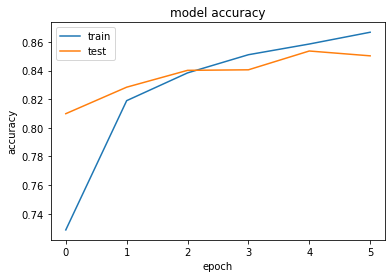

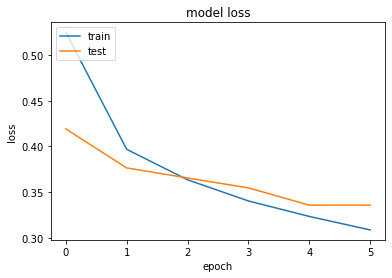

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()